# Group Level Sparkify

In [2]:
# find spark content
import findspark
findspark.init()

# Pre-processing packages
import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, desc, col, max as scala_max, sum as scala_sum, split as scala_split
from pyspark.sql.functions import size as scala_len
from pyspark.sql.functions import sum as scala_sum, unix_timestamp, avg as scala_avg, count as scala_count
from pyspark.sql.functions import from_unixtime, col
from pyspark.sql.types import DateType, IntegerType
from pyspark.sql.types import StringType, BooleanType, TimestampType, ArrayType
from pyspark.sql import Window

# Machine Learning Packages
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer, VectorAssembler, StringIndexer, IndexToString
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator

# Random Forest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [3]:
# create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

---

# Load and Clean Dataset

In [4]:
# Read in full sparkify dataset
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)

---

# Exploring Data and Pre-processing

## Schema

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Head Example

In [6]:
df.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

## Drop Irrelevant

In [7]:
drop_list = ['firstName', 'lastName', 'auth', 'method', 'sessionId', 'song', 
             'status', 'registration', 'userAgent', 'artist', 'itemInSession']

for drop in drop_list:
    df = df.drop(drop)

## Verify Schema

In [8]:
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- userId: string (nullable = true)



## Gender Distribution

In [9]:
df.groupBy("gender").count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+



## Location Distribution

In [10]:
df.groupBy("location").count().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL| 1229|
|Atlantic City-Ham...| 2176|
|Deltona-Daytona B...|   73|
|San Diego-Carlsba...|  754|
|Cleveland-Elyria, OH| 1392|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|Birmingham-Hoover...|   75|
|  Corpus Christi, TX|   11|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|          Albany, OR|   23|
|   Winston-Salem, NC|  819|
|     Bakersfield, CA| 1775|
|Los Angeles-Long ...|30131|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Phoenix-Mesa-Scot...| 4846|
+--------------------+-----+
only showing top 20 rows



## stateCode Feature Engineering (dropped)

In [11]:
df_grp = df.withColumn("stateCode", scala_split(df.location, ',')\
    .getItem(1))\
    .select(["stateCode", 'location'])\
    .distinct()

df_grp.filter(df_grp.stateCode == ' IL-IN-WI').collect()

[Row(stateCode=' IL-IN-WI', location='Chicago-Naperville-Elgin, IL-IN-WI')]

> It contains multiple locations.

## multiState Feature Engineering

In [12]:
multi_state_indicator = udf(lambda x: 1 if x > 1 else 0, IntegerType())

df = df.withColumn("stateCode", scala_split(df.location, ',').getItem(1)).drop('location')
df = df.withColumn("multiState", multi_state_indicator(scala_len(scala_split(df.stateCode, '-')))).drop('stateCode')
df.select('multiState').distinct().show()
df.show()

+----------+
|multiState|
+----------+
|         1|
|         0|
+----------+

+------+---------+-----+---------------+-------------+------+----------+
|gender|   length|level|           page|           ts|userId|multiState|
+------+---------+-----+---------------+-------------+------+----------+
|     M|277.89016| paid|       NextSong|1538352117000|    30|         0|
|     M|236.09424| free|       NextSong|1538352180000|     9|         1|
|     M| 282.8273| paid|       NextSong|1538352394000|    30|         0|
|     M|262.71302| free|       NextSong|1538352416000|     9|         1|
|     M|223.60771| paid|       NextSong|1538352676000|    30|         0|
|     M|208.29995| free|       NextSong|1538352678000|     9|         1|
|     M|260.46649| free|       NextSong|1538352886000|     9|         1|
|     M|185.44281| paid|       NextSong|1538352899000|    30|         0|
|     M|     null| paid|Add to Playlist|1538352905000|    30|         0|
|     M|134.47791| paid|       NextSong|15383

## Page Unique Values

In [13]:
df.select("page").distinct().show(100)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



# More Pre-processing

## Cleaning Date

In [14]:
# date addition
to_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime("%Y-%m-%d"))
df = df.withColumn("date", to_datetime(df.ts))

# datime addition
to_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).isoformat())
df = df.withColumn("datetime", to_datetime(df.ts))

---

## Cancellation Phase

In [15]:
# window function for values unbounded preceding the label
window_fun = (Window.partitionBy("userId")
             .orderBy(desc("ts"))
             .rangeBetween(Window.unboundedPreceding, 0))

# flagging cancellations
def user_defined_function(phase): 
    return udf(lambda x: 
               1 if x == phase
               else 0, IntegerType())
    
flag_cancel_func = user_defined_function("Cancellation Confirmation")

# adding downgrade indicator indicator
df = df.withColumn("cancel_ind", flag_cancel_func("page"))

# adding churn flag
df = df.withColumn("cancel_user", 
                   scala_sum("cancel_ind").over(window_fun))

---

## Downgrade Phase

In [16]:
# flagging downgrades
flag_downgraded_func = user_defined_function("Submit Downgrade")

# adding indicator
df = df.withColumn("downgrade_ind", flag_downgraded_func("page"))

# sum flags over the window statement
df = df.withColumn("downgrade_phase", 
                   scala_sum("downgrade_ind").over(window_fun))

---

## Period Between Downgrade

### Period Spark Version

In [17]:
# period_function = udf(lambda page: int(page=='Downgrade'), IntegerType())

# over_ts_func = (Window.partitionBy("userId")
#     .orderBy(desc("ts"))
#     .rangeBetween(Window.unboundedPreceding, 0))

# df_ready = (df.filter((df.page == 'NextSong') | (df.page == 'Downgrade'))
#     .select(["userId", "page", "gender", "length", "ts", "multiState", "level", "date", "cancel_user"])
#     .withColumn("downgrade_ind", period_function(col("page")))
#     .withColumn("period", scala_sum("downgrade_ind").over(over_ts_func))
# )

### Period SQL Version

In [18]:
df.createOrReplaceTempView("sparkify_table")

downgrade_indicator = spark.sql("""
SELECT 
    userId, 
    page, 
    gender,
    level,
    length,
    date,
    ts,
    multiState,
    CASE 
        WHEN page = 'Downgrade' 
        THEN 1 
        ELSE 0 
    END AS downgrade_ind,
    cancel_user
FROM sparkify_table
WHERE (page = 'NextSong') or (page = 'Downgrade')
""")

downgrade_indicator.createOrReplaceTempView('downgrade_table')

df_ready = spark.sql("""
SELECT
    *,
    SUM(downgrade_ind)
    OVER(PARTITION BY userId 
        ORDER BY ts DESC 
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS downgrade_period
FROM downgrade_table
--WHERE userId = 200011
""")

df_ready = df_ready.drop('downgrade_ind')

df_ready.head()

Row(userId='100010', page='NextSong', gender='F', level='free', length=185.25995, date='2018-11-21', ts=1542823951000, multiState=0, cancel_user=0, downgrade_period=0)

## Downgrade and Cancelation Descriptive Statistics

In [92]:
df_explore = df_ready.groupBy(["userId", "gender"]).agg(scala_max(col("cancel_user")).alias("canceled"), 
                                           scala_max(col("downgrade_period")).alias("downgrade_attempts"),
                                           scala_count(col("length")).alias("listened_songs"))

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
df_explore.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- canceled: long (nullable = true)
 |-- downgrade_attempts: long (nullable = true)
 |-- listened_songs: long (nullable = false)



In [95]:
user_count = df_explore.select("userId").distinct().count()
print(f"There are {user_count} number of users from which we are doing churn prediction.")

There are 225 number of users from which we are doing churn prediction.


### Canceled Users By Gender

In [96]:
c_bygen = df_explore\
    .groupBy("gender")\
    .agg(scala_sum(col("canceled")).alias('canceled'), 
         scala_count(col("userId")).alias('user_count')).toPandas()\
    .assign(cancel_percent = lambda x: x.canceled/x.user_count)

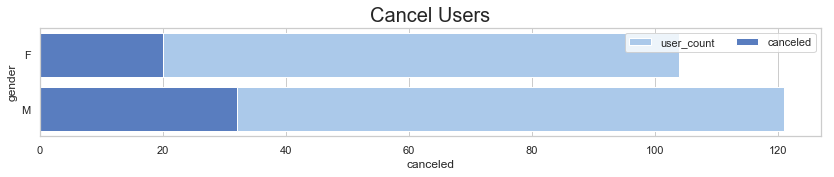

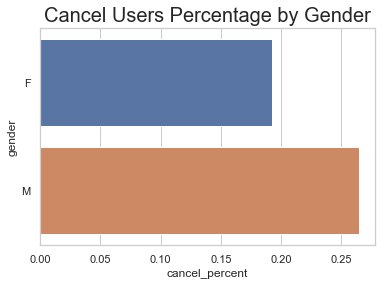

In [97]:
f, ax = plt.subplots(figsize=(14, 2))

sns.set(style="whitegrid")

plt.title("Cancel Users", size=20)
sns.set_color_codes("pastel")
sns.barplot(y='gender', x='user_count', data=c_bygen, label='user_count', color='b')

sns.set_color_codes("muted")
sns.barplot(y='gender', x='canceled', data=c_bygen, label='canceled', color='b')

# Add a legend and informative axis label
ax.legend(ncol=3, loc="best", frameon=True)
plt.show()

plt.title("Cancel Users Percentage by Gender", size=20)
sns.barplot(y='gender', x='cancel_percent', data=c_bygen)
plt.show()

> More males have canceled the services.

### Downgraded Attempts Cancelled

In [98]:
d_attempt = df_explore\
    .groupBy(["downgrade_attempts", "canceled"])\
    .count()\
    .select(["downgrade_attempts", "canceled"]).toPandas()

In [100]:
d_attempt.groupby("downgrade_attempts").agg({'canceled': ['sum', 'count']})

canceled      
                        sum count
downgrade_attempts               
0                         1     2
1                         1     2
2                         1     2
3                         1     2
4                         1     1
5                         1     2
6                         1     2
7                         1     2
8                         1     2
9                         1     2
10                        1     2
11                        0     1
12                        1     2
13                        1     2
14                        0     1
15                        1     2
16                        0     1
17                        0     1
18                        1     2
19                        0     1
20                        0     1
21                        0     1
22                        1     2
23                        1     2
24                        0     1
25                        0     1
26                        1     2
27                        0     1
28                        0     1
30                        0     1
31                        0     1
32                        0     1
37                        0     1
39                        1     1
41                        0     1
42                        0     1
44                        0     1
50                        0     1
68                        0     1
73                        0     1

### Multi-State Cacellations

## Gender Endoder

In [18]:
df.select('gender').distinct().show()

+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+



*null genders will have 0 and 0 for both Male and Female columns.

In [19]:
male_encoder = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
df_ready = df_ready.withColumn("Male", male_encoder(df_ready.gender))

female_encoder = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
df_ready = df_ready.withColumn("Female", female_encoder(df_ready.gender))

df_ready = df_ready.drop('gender')

## Level Encoder

In [20]:
df.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [21]:
free_encoder = udf(lambda x: 1 if x == 'free' else 0, IntegerType())
df_ready = df_ready.withColumn('free', free_encoder(df_ready.level))

paid_encoder = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df_ready = df_ready.withColumn('paid', paid_encoder(df_ready.level))

df_ready = df_ready.drop('level')

## Feature Engineering

### Daily Seconds Used

In [22]:
df_ready.printSchema()

root
 |-- userId: string (nullable = true)
 |-- page: string (nullable = true)
 |-- length: double (nullable = true)
 |-- date: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- multiState: integer (nullable = true)
 |-- cancel_user: long (nullable = true)
 |-- downgrade_period: long (nullable = true)
 |-- Male: integer (nullable = true)
 |-- Female: integer (nullable = true)
 |-- free: integer (nullable = true)
 |-- paid: integer (nullable = true)



In [23]:
over_date_func = (Window.partitionBy(["userId", "date"]))

# also filtering only on songs
df_ready = df_ready.filter((df.page == 'NextSong'))\
    .withColumn("DailySeconds", scala_sum("length").over(over_date_func))

df_ready = df_ready.drop('length').drop('page')

### Daily Use Count

In [24]:
df_ready = df_ready.withColumn("DailyUse", scala_count("userId").over(over_date_func))

### Feature Columns

In [25]:
# get available columns
feature_columns = df_ready.columns

# removed column
for col in ['userId', 'date', 'cancel_user', 'ts']:
    feature_columns.remove(col)

print("Feature Columns")
feature_columns

Feature Columns


['multiState',
 'downgrade_period',
 'Male',
 'Female',
 'free',
 'paid',
 'DailySeconds',
 'DailyUse']

### Table Prep

In [26]:
data = df_ready

# assembling the predictor features
feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data = feature_assembler.transform(data)

# indexing the labels
labelIndexer = StringIndexer(inputCol="cancel_user", outputCol="indexedLabel").fit(data)

# indexit the features
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# index to string predictions
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Processing

### Train & Test Split

In [27]:
trainingData, testData = data.randomSplit([0.7, 0.3], seed=42)
trainingData.count(), testData.count()

(160001, 68107)

## Random Forest Classifier Model

### Pipelines

In [28]:
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

### No Validation Model Implementation

In [29]:
model = pipeline.fit(trainingData)

In [30]:
pred = model.transform(testData)

In [31]:
for metric_name in ['accuracy', 'weightedPrecision', 'weightedRecall', 'f1']:
    evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName=metric_name)
    accuracy = evaluator.evaluate(pred)
    print(f"{metric_name} = {accuracy:2.2%}")

accuracy = 84.03%
weightedPrecision = 86.59%
weightedRecall = 84.03%
f1 = 76.89%


### Cross Validation Implementation 

In [32]:
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 20, 30])\
    .addGrid(rf.maxDepth, [4, 8, 12])\
    .build()

In [33]:
crossval = CrossValidator(estimator=pipeline, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=MulticlassClassificationEvaluator(labelCol='indexedLabel', 
                                                                      predictionCol='prediction', 
                                                                      metricName='accuracy'), 
                          numFolds=3)

In [34]:
trainingData.printSchema()

root
 |-- userId: string (nullable = true)
 |-- date: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- multiState: integer (nullable = true)
 |-- cancel_user: long (nullable = true)
 |-- downgrade_period: long (nullable = true)
 |-- Male: integer (nullable = true)
 |-- Female: integer (nullable = true)
 |-- free: integer (nullable = true)
 |-- paid: integer (nullable = true)
 |-- DailySeconds: double (nullable = true)
 |-- DailyUse: long (nullable = false)
 |-- features: vector (nullable = true)



In [35]:
cvmodel = crossval.fit(trainingData)

In [36]:
cv_pred = cvmodel.transform(testData)

In [37]:
cv_pred.printSchema()

root
 |-- userId: string (nullable = true)
 |-- date: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- multiState: integer (nullable = true)
 |-- cancel_user: long (nullable = true)
 |-- downgrade_period: long (nullable = true)
 |-- Male: integer (nullable = true)
 |-- Female: integer (nullable = true)
 |-- free: integer (nullable = true)
 |-- paid: integer (nullable = true)
 |-- DailySeconds: double (nullable = true)
 |-- DailyUse: long (nullable = false)
 |-- features: vector (nullable = true)
 |-- indexedLabel: double (nullable = false)
 |-- indexedFeatures: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)
 |-- predictedLabel: string (nullable = true)



# Testing MulticlassMetrics

In [38]:
metrics = MulticlassMetrics(cv_pred.rdd.map(lambda x: (x.prediction, x.indexedLabel)))

In [39]:
# Overall statistics
accuracy = metrics.accuracy
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Accuracy = %s" % accuracy)
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

Summary Stats
Accuracy = 0.8698078024285316
Precision = 0.8698078024285316
Recall = 0.8698078024285316
F1 Score = 0.8698078024285316


In [40]:
# Weighted stats
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Weighted recall = 0.8698078024285316
Weighted precision = 0.8858590725853408
Weighted F(1) Score = 0.8307413824426383
Weighted F(0.5) Score = 0.834000875749273
Weighted false positive rate = 0.6758952095320233


**Evaluation Metrics:**

Accuracy: $\frac{TP+TN}{TP+TN+FP+FN}$

Precission: $\frac{TP}{TP+FP}$

Recall: $\frac{TP}{TP+FN}$

f1: $2 *\frac{precision * recall}{precision + recall}$